# Task 1:
Developing a multi-layer neural network for classification using numpy.
### Features
- Sigmoid, ReLU and Softmax Layers with forward and backward pass
- Inverted dropout
- Fully parametrizable neural network class
- Two optimizers (SGD & SGD with momentum)

In [ ]:
%pip install tensorflow

## Importing libraries
We will be using the CIFAR-10 dataset from Keras.

In [120]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [121]:
# Setting a fixed seed for reproducibility
SEED = 17
np.random.seed(SEED)

In [122]:
# Fetch CIFAR-10 data and split into train/test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Split training data into training and validation sets (10% for validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

# Flatten data
X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(np.float32) / 255.0
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1).astype(np.float32) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(np.float32) / 255.0

# Print data shapes
print(f"Train Images Shape: {X_train_flat.shape}, Train Labels Shape: {y_train.shape}")
print(f"Validation Images Shape: {X_valid_flat.shape}, Validation Labels Shape: {y_valid.shape}")
print(f"Test Images Shape: {X_test_flat.shape}, Test Labels Shape: {y_test.shape}")

Train Images Shape: (45000, 3072), Train Labels Shape: (45000, 1)
Validation Images Shape: (5000, 3072), Validation Labels Shape: (5000, 1)
Test Images Shape: (10000, 3072), Test Labels Shape: (10000, 1)


The data has been correctly split from 50,000 32x32 images to 45,000 training images and 5,000 validation images. 10,000 images for testing have also been correctly imported.

## Visualising the dataset

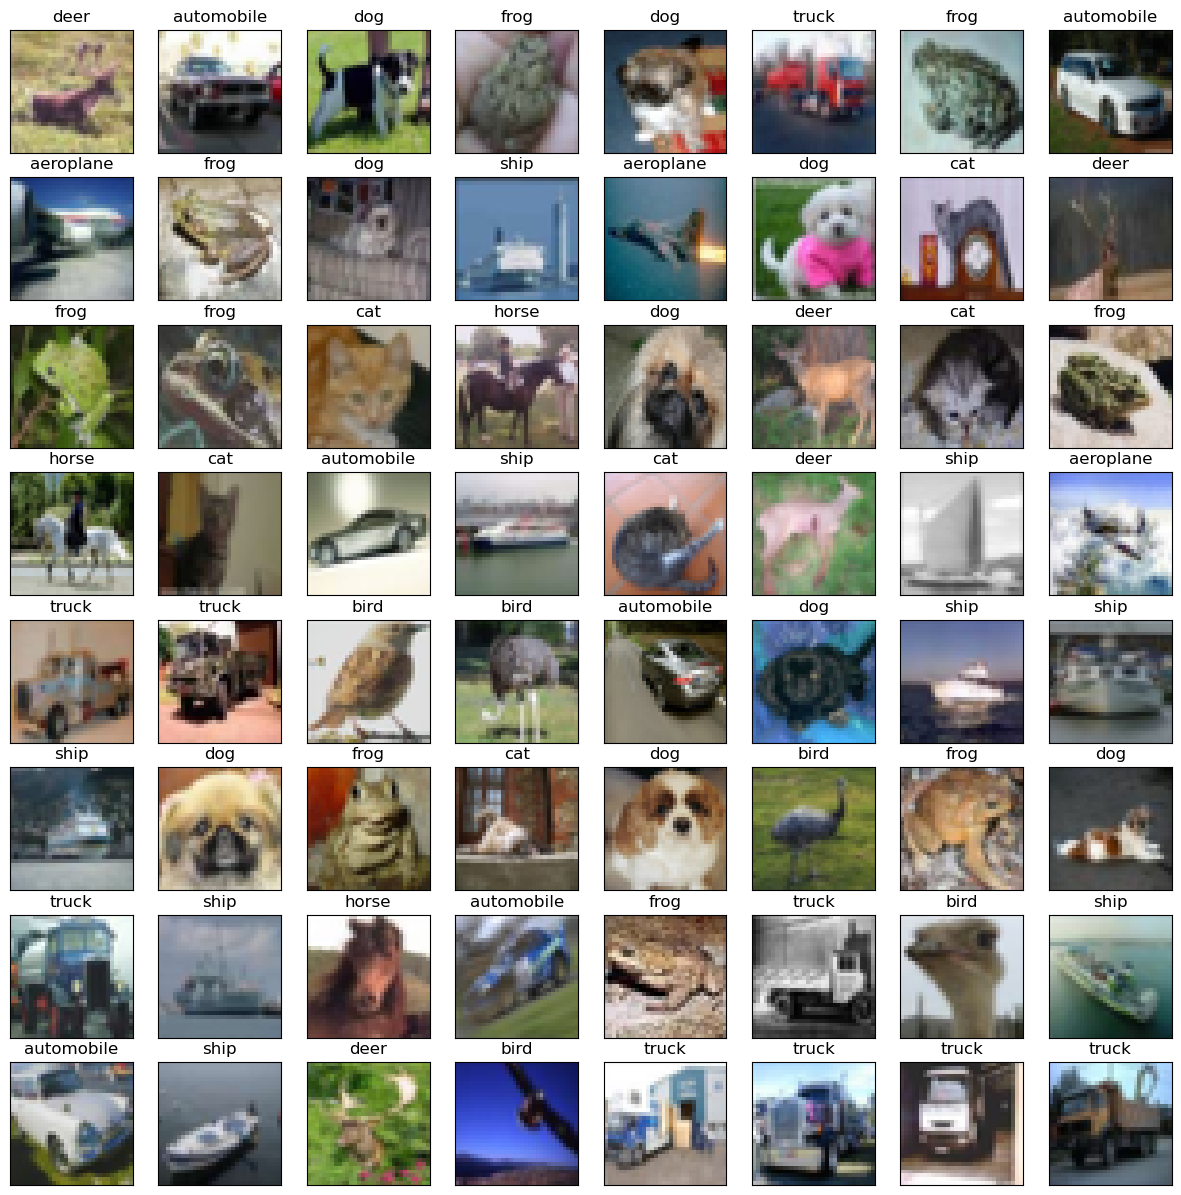

In [123]:
# CIFAR-10 classes
class_names = ["aeroplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Create a new figure
plt.figure(figsize=(15, 15))

# Loop over the first 64 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Reshape the flattened image back to (32, 32, 3) if necessary
    img = X_train[i].reshape(32, 32, 3) if X_train[i].shape == (3072,) else X_train[i]
    
    # Display the image
    plt.imshow(img)

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

## Implementing the Neural Network
We built a fully connected neural network with customizable layers to evaluate its performance on CIFAR-10 for 10-class classification. The network includes ReLU, Sigmoid, and Softmax activations, dropout for regularization, and is trained using gradient descent with a learning rate of 0.01. The model architecture consists of 10 input nodes, two hidden layers with 16 and 8 nodes, and 10 output nodes. Training was performed over 30 epochs with a batch size of 32, and both training and validation loss were tracked.

Epoch 1/30, Loss: 2.1353, Accuracy: 0.2361
Epoch 2/30, Loss: 1.9396, Accuracy: 0.3139
Epoch 3/30, Loss: 1.8783, Accuracy: 0.3389
Epoch 4/30, Loss: 1.8313, Accuracy: 0.3568
Epoch 5/30, Loss: 1.7952, Accuracy: 0.3696
Epoch 6/30, Loss: 1.7630, Accuracy: 0.3840
Epoch 7/30, Loss: 1.7475, Accuracy: 0.3904
Epoch 8/30, Loss: 1.7211, Accuracy: 0.3978
Epoch 9/30, Loss: 1.7016, Accuracy: 0.4104
Epoch 10/30, Loss: 1.6802, Accuracy: 0.4189
Epoch 11/30, Loss: 1.6683, Accuracy: 0.4213
Epoch 12/30, Loss: 1.6468, Accuracy: 0.4287
Epoch 13/30, Loss: 1.6387, Accuracy: 0.4290
Epoch 14/30, Loss: 1.6265, Accuracy: 0.4356
Epoch 15/30, Loss: 1.6137, Accuracy: 0.4410
Epoch 16/30, Loss: 1.6032, Accuracy: 0.4426
Epoch 17/30, Loss: 1.5988, Accuracy: 0.4468
Epoch 18/30, Loss: 1.5810, Accuracy: 0.4512
Epoch 19/30, Loss: 1.5771, Accuracy: 0.4543
Epoch 20/30, Loss: 1.5615, Accuracy: 0.4573
Epoch 21/30, Loss: 1.5554, Accuracy: 0.4626
Epoch 22/30, Loss: 1.5460, Accuracy: 0.4642
Epoch 23/30, Loss: 1.5413, Accuracy: 0.46

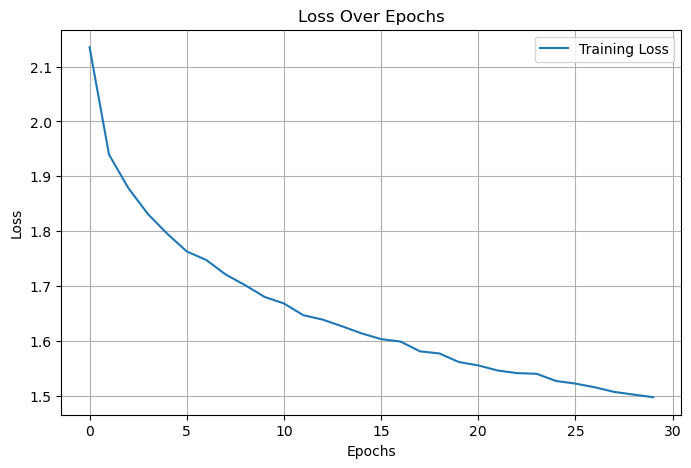

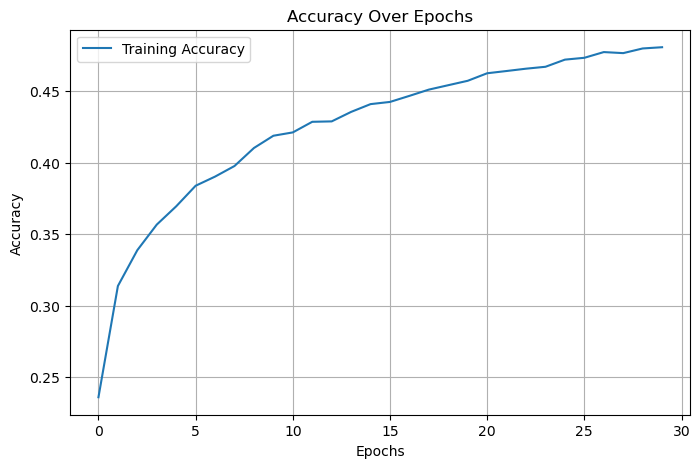

In [124]:
# Activation functions
class ActivationFunctions:
  @staticmethod
  def softmax(x):
      exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
      return exp_x / np.sum(exp_x, axis=1, keepdims=True)

  @staticmethod
  def sigmoid(x):
      return 1 / (1 + np.exp(-x))

  @staticmethod
  def relu(x):
      return np.maximum(0, x)

  @staticmethod
  def sigmoid_derivative(x):
      return x * (1 - x)

  @staticmethod
  def relu_derivative(x):
      return (x > 0).astype(float)

# Layer class
class Layer:
  def __init__(self, nodes_of_prev, nodes, activation):
      self.nodes = nodes
      self.activation = activation
      self.weights = np.random.randn(nodes_of_prev, nodes) * np.sqrt(2.0 / nodes_of_prev)
      self.biases = np.zeros((1, nodes))

  def forward(self, input_data):
      self.z = np.dot(input_data, self.weights) + self.biases
      if self.activation == "sigmoid":
          self.a = ActivationFunctions.sigmoid(self.z)
      elif self.activation == "relu":
          self.a = ActivationFunctions.relu(self.z)
      elif self.activation == "softmax":
          self.a = ActivationFunctions.softmax(self.z)
      else:
          raise ValueError(f"Unsupported activation: {self.activation}")
      return self.a

  def backward(self, da, input_data):
      m = input_data.shape[0]
      if self.activation == "sigmoid":
          dz = da * ActivationFunctions.sigmoid_derivative(self.a)
      elif self.activation == "relu":
          dz = da * ActivationFunctions.relu_derivative(self.a)
      else:
          dz = da

      dw = np.dot(input_data.T, dz) / m
      db = np.sum(dz, axis=0, keepdims=True) / m
      da_prev = np.dot(dz, self.weights.T)

      return dw, db, da_prev

# Optimizers
class SGDOptimizer:
  def __init__(self, learning_rate=0.01):
      self.learning_rate = learning_rate

  def update(self, weights, biases, dw, db):
      weights -= self.learning_rate * dw
      biases -= self.learning_rate * db
      return weights, biases

class SGDmomentumOptimizer:
  def __init__(self, learning_rate=0.01, momentum=0.9):
      self.learning_rate = learning_rate
      self.momentum = momentum
      self.velocity_w = None
      self.velocity_b = None

  def update(self, weights, biases, dw, db):
      if self.velocity_w is None:
          self.velocity_w = np.zeros_like(dw)
          self.velocity_b = np.zeros_like(db)

      self.velocity_w = self.momentum * self.velocity_w - self.learning_rate * dw
      self.velocity_b = self.momentum * self.velocity_b - self.learning_rate * db

      weights += self.velocity_w
      biases += self.velocity_b

      return weights, biases

# Neural Network class
class NeuralNetwork:
  def __init__(self, layers_config, learning_rate=0.01, optimizer_type="SGD", momentum=0.9):
      self.layers = []
      self.learning_rate = learning_rate
      if optimizer_type == "SGD":
          self.optimizer = SGDOptimizer(learning_rate)
      elif optimizer_type == "SGDmomentum":
          self.optimizer = SGDmomentumOptimizer(learning_rate, momentum)
      else:
          raise ValueError(f"Unsupported optimizer: {optimizer_type}")

      for i in range(len(layers_config) - 1):
          self.layers.append(Layer(layers_config[i], layers_config[i + 1], activation="relu" if i < len(layers_config) - 2 else "softmax"))

  def forward(self, X):
      self.a_cache = [X]
      for layer in self.layers:
          X = layer.forward(X)
          self.a_cache.append(X)
      return X

  def backward(self, X, Y):
      da = self.a_cache[-1] - Y
      grads = []

      for i in reversed(range(len(self.layers))):
          input_data = self.a_cache[i]
          dw, db, da = self.layers[i].backward(da, input_data)
      
      grads.insert(0, (dw, db))

      return grads

  def update_params(self, grads):
      for i, (dw, db) in enumerate(grads):
          layer = self.layers[i]
          layer.weights, layer.biases = self.optimizer.update(layer.weights, layer.biases, dw, db)

  def train(self, X_train, Y_train, X_valid, Y_valid, epochs=30, batch_size=64):
      train_loss = []
      val_loss = []
      train_accuracy = []
      m = X_train.shape[0]

      for epoch in range(epochs):
          epoch_loss = 0
          epoch_acc = 0
          indices = np.random.permutation(m)
          X_train, Y_train = X_train[indices], Y_train[indices]

          for i in range(0, m, batch_size):
              X_batch = X_train[i:i + batch_size]
              Y_batch = Y_train[i:i + batch_size]

              Y_pred = self.forward(X_batch)
              loss = -np.sum(Y_batch * np.log(Y_pred + 1e-8)) / batch_size
              accuracy = np.mean(np.argmax(Y_pred, axis=1) == np.argmax(Y_batch, axis=1))

              epoch_loss += loss
              epoch_acc += accuracy

              grads = self.backward(X_batch, Y_batch)
              self.update_params(grads)

          train_loss.append(epoch_loss / ((m + batch_size - 1) // batch_size))
          val_loss_epoch = -np.sum(Y_valid * np.log(self.forward(X_valid) + 1e-8)) / Y_valid.shape[0]
          val_loss.append(val_loss_epoch)

          print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss[-1]:.4f}, Accuracy: {epoch_acc / ((m + batch_size - 1) // batch_size):.4f}")
          train_accuracy.append(epoch_acc / ((m + batch_size - 1) // batch_size))

      return train_loss, train_accuracy, val_loss

  def plot_loss(self, train_loss, val_loss=None):
      plt.figure(figsize=(8, 5))
      plt.plot(train_loss, label="Training Loss")
      if val_loss:
          plt.plot(val_loss, label="Validation Loss", linestyle="--")
      plt.title("Loss Over Epochs")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.grid(True)
      plt.show()

  def plot_accuracy(self, train_accuracy):
      plt.figure(figsize=(8, 5))
      plt.plot(train_accuracy, label="Training Accuracy")
      plt.title("Accuracy Over Epochs")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.legend()
      plt.grid(True)
      plt.show()

# One-hot encode labels
y_train = np.eye(10)[y_train.flatten().astype(int)]
y_valid = np.eye(10)[y_valid.flatten().astype(int)]
y_test = np.eye(10)[y_test.flatten().astype(int)]

# Define parameters
input_size = 32 * 32 * 3
output_size = 10
epochs = 30
learning_rate = 0.1

# Train neural network
nn = NeuralNetwork([input_size, 128, output_size], learning_rate=learning_rate)
train_loss, train_accuracy, val_loss = nn.train(X_train_flat, y_train, X_valid_flat, y_valid, epochs=epochs, batch_size=64)

By default, the neural network will use the configuration of 128 nodes and ReLU activation, with the output layer being Softmax.

In [ ]:
nn.plot_loss(train_loss)

In [ ]:
nn.plot_accuracy(train_accuracy)

## 2 Sigmoid, 1 ReLU

Epoch 1/30, Loss: 2.3968, Accuracy: 0.1128
Epoch 2/30, Loss: 2.3358, Accuracy: 0.1113
Epoch 3/30, Loss: 2.3207, Accuracy: 0.1170
Epoch 4/30, Loss: 2.3115, Accuracy: 0.1256
Epoch 5/30, Loss: 2.3043, Accuracy: 0.1369
Epoch 6/30, Loss: 2.2985, Accuracy: 0.1428
Epoch 7/30, Loss: 2.2937, Accuracy: 0.1455
Epoch 8/30, Loss: 2.2896, Accuracy: 0.1479
Epoch 9/30, Loss: 2.2857, Accuracy: 0.1485
Epoch 10/30, Loss: 2.2818, Accuracy: 0.1483
Epoch 11/30, Loss: 2.2779, Accuracy: 0.1474
Epoch 12/30, Loss: 2.2745, Accuracy: 0.1470
Epoch 13/30, Loss: 2.2713, Accuracy: 0.1484
Epoch 14/30, Loss: 2.2684, Accuracy: 0.1487
Epoch 15/30, Loss: 2.2656, Accuracy: 0.1490
Epoch 16/30, Loss: 2.2631, Accuracy: 0.1497
Epoch 17/30, Loss: 2.2606, Accuracy: 0.1505
Epoch 18/30, Loss: 2.2583, Accuracy: 0.1507
Epoch 19/30, Loss: 2.2561, Accuracy: 0.1507
Epoch 20/30, Loss: 2.2540, Accuracy: 0.1512
Epoch 21/30, Loss: 2.2520, Accuracy: 0.1517
Epoch 22/30, Loss: 2.2501, Accuracy: 0.1520
Epoch 23/30, Loss: 2.2483, Accuracy: 0.15

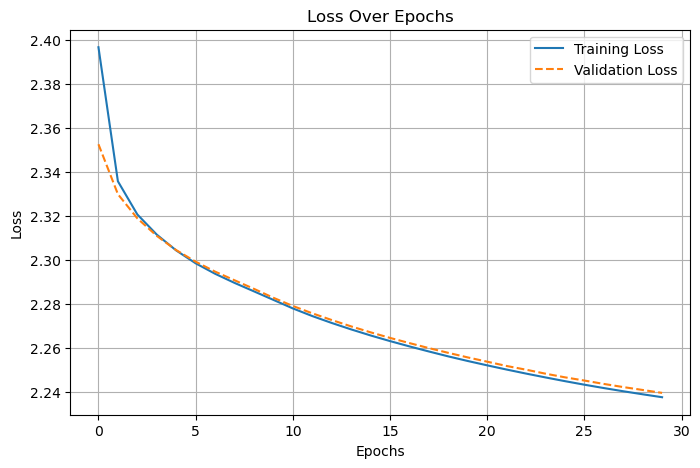

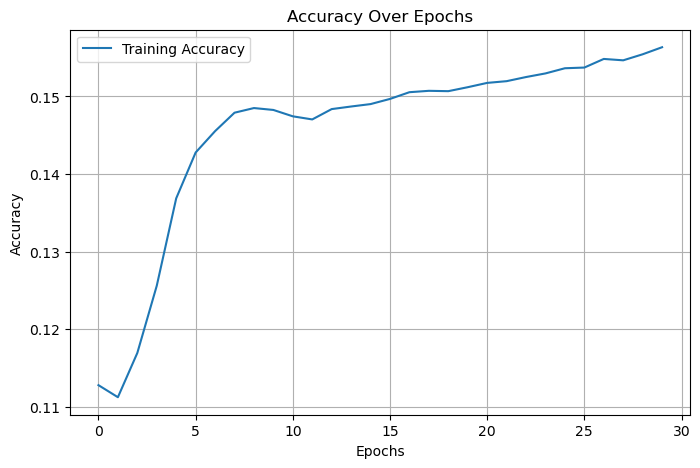

In [127]:
nn_variant = NeuralNetwork([input_size, 150, 100, 50, output_size], learning_rate=0.005)

# Set custom activations for each layer
nn_variant.layers[0].activation = "sigmoid"   # First hidden layer uses Sigmoid
nn_variant.layers[1].activation = "relu"     # Second hidden layer uses ReLU
nn_variant.layers[2].activation = "sigmoid"  # Third hidden layer uses Sigmoid
nn_variant.layers[-1].activation = "softmax" # Output layer uses Softmax

# Training
variant_loss, variant_accuracy, variant_val_loss = nn_variant.train(X_train_flat, y_train, X_valid_flat, y_valid, epochs=epochs, batch_size=64)

# Plot the loss graph
nn_variant.plot_loss(variant_loss, variant_val_loss)

# Plot the accuracy graph
nn_variant.plot_accuracy(variant_accuracy)

## 3 ReLU with SGD

Epoch 1/30, Loss: 2.0618, Accuracy: 0.2595
Epoch 2/30, Loss: 1.8760, Accuracy: 0.3428
Epoch 3/30, Loss: 1.8104, Accuracy: 0.3691
Epoch 4/30, Loss: 1.7717, Accuracy: 0.3834
Epoch 5/30, Loss: 1.7409, Accuracy: 0.3932
Epoch 6/30, Loss: 1.7166, Accuracy: 0.4033
Epoch 7/30, Loss: 1.6993, Accuracy: 0.4078
Epoch 8/30, Loss: 1.6803, Accuracy: 0.4175
Epoch 9/30, Loss: 1.6664, Accuracy: 0.4209
Epoch 10/30, Loss: 1.6522, Accuracy: 0.4252
Epoch 11/30, Loss: 1.6413, Accuracy: 0.4311
Epoch 12/30, Loss: 1.6286, Accuracy: 0.4354
Epoch 13/30, Loss: 1.6176, Accuracy: 0.4386
Epoch 14/30, Loss: 1.6090, Accuracy: 0.4422
Epoch 15/30, Loss: 1.5992, Accuracy: 0.4444
Epoch 16/30, Loss: 1.5897, Accuracy: 0.4485
Epoch 17/30, Loss: 1.5809, Accuracy: 0.4530
Epoch 18/30, Loss: 1.5733, Accuracy: 0.4551
Epoch 19/30, Loss: 1.5643, Accuracy: 0.4586
Epoch 20/30, Loss: 1.5572, Accuracy: 0.4592
Epoch 21/30, Loss: 1.5510, Accuracy: 0.4646
Epoch 22/30, Loss: 1.5430, Accuracy: 0.4673
Epoch 23/30, Loss: 1.5382, Accuracy: 0.46

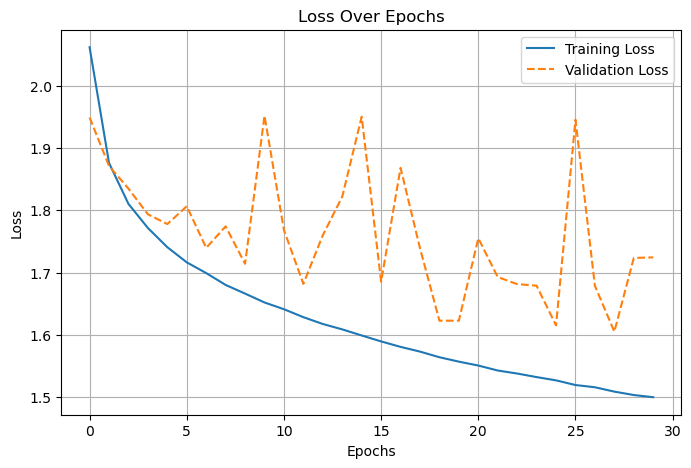

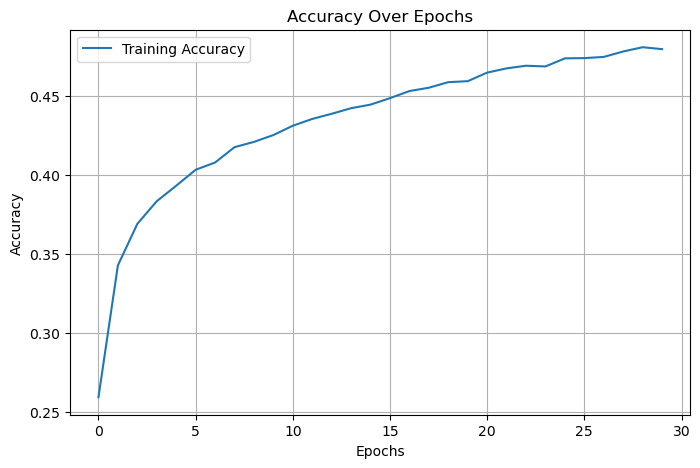

In [128]:
nn_relu_sgd = NeuralNetwork([input_size, 150, 100, 50, output_size], learning_rate=0.005, optimizer_type="SGD")

# Set custom activations for each layer
nn_relu_sgd.layers[0].activation = "relu"
nn_relu_sgd.layers[1].activation = "relu"
nn_relu_sgd.layers[2].activation = "relu"
nn_relu_sgd.layers[-1].activation = "softmax"

# Training
relu_sgd_loss, relu_sgd_accuracy, relu_sgd_val_loss = nn_relu_sgd.train(X_train_flat, y_train, X_valid_flat, y_valid, epochs=epochs, batch_size=64)

# Plot the loss graph
nn_relu_sgd.plot_loss(relu_sgd_loss, relu_sgd_val_loss)

# Plot the accuracy graph
nn_relu_sgd.plot_accuracy(relu_sgd_accuracy)

## 3 Sigmoid layers and SGD with momentum

Epoch 1/30, Loss: 2.4733, Accuracy: 0.1000
Epoch 2/30, Loss: 2.4524, Accuracy: 0.1000
Epoch 3/30, Loss: 2.4469, Accuracy: 0.0999
Epoch 4/30, Loss: 2.4430, Accuracy: 0.0999
Epoch 5/30, Loss: 2.4396, Accuracy: 0.0999
Epoch 6/30, Loss: 2.4367, Accuracy: 0.0999
Epoch 7/30, Loss: 2.4344, Accuracy: 0.0999
Epoch 8/30, Loss: 2.4325, Accuracy: 0.1001
Epoch 9/30, Loss: 2.4308, Accuracy: 0.1009
Epoch 10/30, Loss: 2.4294, Accuracy: 0.1012
Epoch 11/30, Loss: 2.4281, Accuracy: 0.1021
Epoch 12/30, Loss: 2.4270, Accuracy: 0.1029
Epoch 13/30, Loss: 2.4259, Accuracy: 0.1041
Epoch 14/30, Loss: 2.4249, Accuracy: 0.1048
Epoch 15/30, Loss: 2.4241, Accuracy: 0.1062
Epoch 16/30, Loss: 2.4233, Accuracy: 0.1082
Epoch 17/30, Loss: 2.4225, Accuracy: 0.1091
Epoch 18/30, Loss: 2.4218, Accuracy: 0.1117
Epoch 19/30, Loss: 2.4212, Accuracy: 0.1122
Epoch 20/30, Loss: 2.4206, Accuracy: 0.1142
Epoch 21/30, Loss: 2.4200, Accuracy: 0.1148
Epoch 22/30, Loss: 2.4194, Accuracy: 0.1169
Epoch 23/30, Loss: 2.4188, Accuracy: 0.11

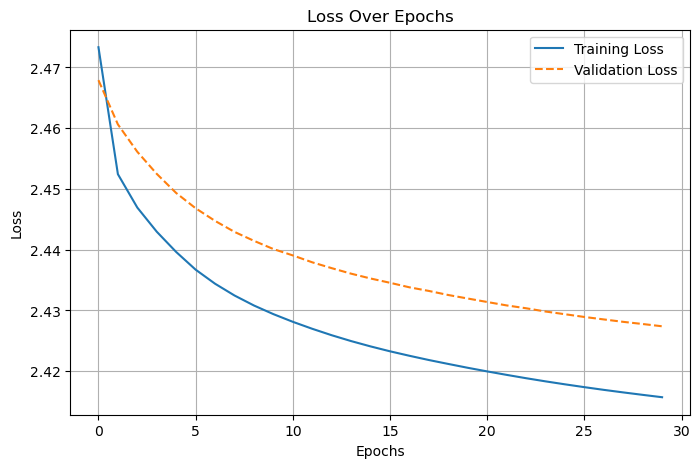

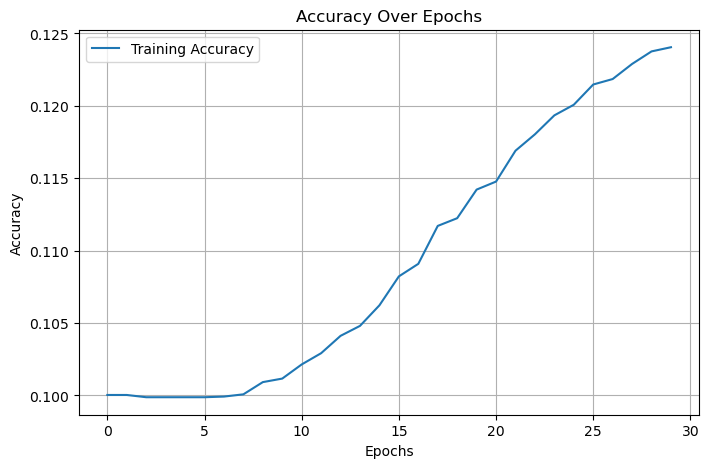

In [129]:
nn_sigmoid_momentum = NeuralNetwork([input_size, 150, 100, 50, output_size], learning_rate=0.005, optimizer_type="SGDmomentum")

# Set custom activations for each layer
nn_sigmoid_momentum.layers[0].activation = "sigmoid"
nn_sigmoid_momentum.layers[1].activation = "sigmoid"
nn_sigmoid_momentum.layers[2].activation = "sigmoid"
nn_sigmoid_momentum.layers[-1].activation = "softmax"

# Training
sigmoid_momentum_loss, sigmoid_momentum_accuracy, sigmoid_momentum_val_loss = nn_sigmoid_momentum.train(X_train_flat, y_train, X_valid_flat, y_valid, epochs=epochs, batch_size=64)

# Plot the loss graph
nn_sigmoid_momentum.plot_loss(sigmoid_momentum_loss, sigmoid_momentum_val_loss)

# Plot the accuracy graph
nn_sigmoid_momentum.plot_accuracy(sigmoid_momentum_accuracy)

## 3 ReLU (default) with Dropout

Epoch 1/30, Loss: 2.3291, Accuracy: 0.1123
Epoch 2/30, Loss: 2.2809, Accuracy: 0.1258
Epoch 3/30, Loss: 2.2708, Accuracy: 0.1351
Epoch 4/30, Loss: 2.2646, Accuracy: 0.1361
Epoch 5/30, Loss: 2.2578, Accuracy: 0.1402
Epoch 6/30, Loss: 2.2513, Accuracy: 0.1465
Epoch 7/30, Loss: 2.2448, Accuracy: 0.1497
Epoch 8/30, Loss: 2.2389, Accuracy: 0.1549
Epoch 9/30, Loss: 2.2357, Accuracy: 0.1560
Epoch 10/30, Loss: 2.2314, Accuracy: 0.1559
Epoch 11/30, Loss: 2.2293, Accuracy: 0.1597
Epoch 12/30, Loss: 2.2264, Accuracy: 0.1608
Epoch 13/30, Loss: 2.2196, Accuracy: 0.1678
Epoch 14/30, Loss: 2.2192, Accuracy: 0.1655
Epoch 15/30, Loss: 2.2165, Accuracy: 0.1684
Epoch 16/30, Loss: 2.2148, Accuracy: 0.1673
Epoch 17/30, Loss: 2.2115, Accuracy: 0.1704
Epoch 18/30, Loss: 2.2088, Accuracy: 0.1728
Epoch 19/30, Loss: 2.2077, Accuracy: 0.1723
Epoch 20/30, Loss: 2.2052, Accuracy: 0.1756
Epoch 21/30, Loss: 2.2061, Accuracy: 0.1746
Epoch 22/30, Loss: 2.2045, Accuracy: 0.1752
Epoch 23/30, Loss: 2.2009, Accuracy: 0.17

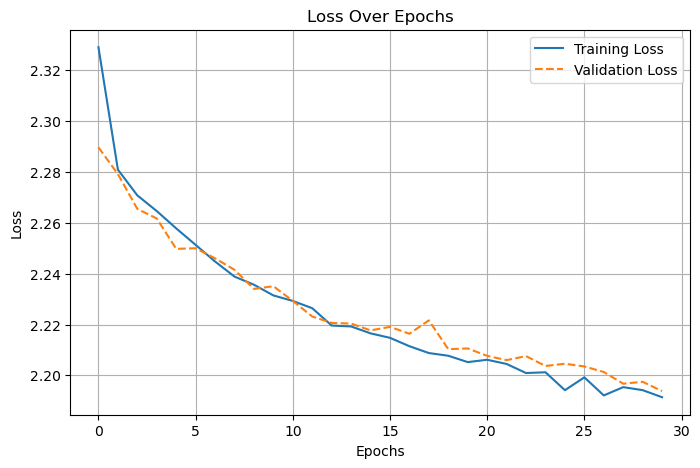

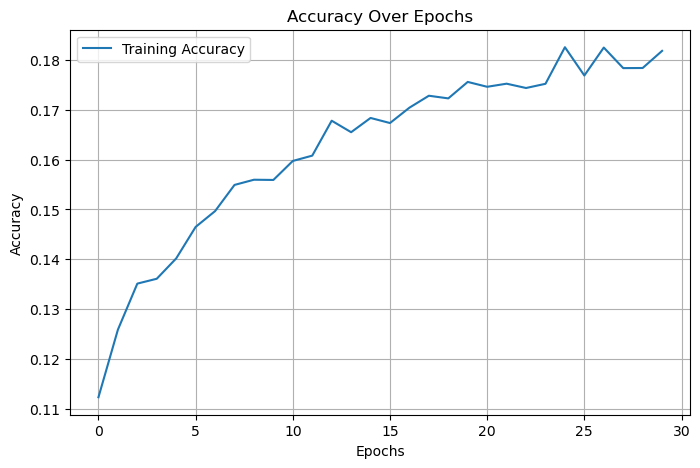

In [130]:
class NeuralNetworkWithDropout(NeuralNetwork):
    def __init__(self, layers_config, dropout_rates=None, learning_rate=0.01, optimizer_type="SGD"):
        super().__init__(layers_config, learning_rate, optimizer_type)
        self.dropout_rates = dropout_rates or [0.0] * len(self.layers)
    
    def forward(self, X):
        self.a_cache = [X]
        for i, layer in enumerate(self.layers):
            X = layer.forward(X)
            if i < len(self.dropout_rates) and self.dropout_rates[i] > 0.0:
                mask = np.random.rand(*X.shape) > self.dropout_rates[i]
                X *= mask  # Apply dropout mask
                X /= (1.0 - self.dropout_rates[i])  # Scale
            self.a_cache.append(X)
        return X

# Training
nn_dropout = NeuralNetworkWithDropout([input_size, 150, 100, 50, output_size], dropout_rates=[0.5, 0.5, 0.0], learning_rate=0.005)
dropout_loss, dropout_accuracy, dropout_val_loss = nn_dropout.train(X_train_flat, y_train, X_valid_flat, y_valid, epochs=epochs, batch_size=64)

# Plot the loss graph
nn_dropout.plot_loss(dropout_loss, dropout_val_loss)

# Plot the accuracy graph
nn_dropout.plot_accuracy(dropout_accuracy)

## 1 Sigmoid

Epoch 1/30, Loss: 2.2239, Accuracy: 0.2054
Epoch 2/30, Loss: 2.1103, Accuracy: 0.2769
Epoch 3/30, Loss: 2.0539, Accuracy: 0.2994
Epoch 4/30, Loss: 2.0175, Accuracy: 0.3131
Epoch 5/30, Loss: 1.9915, Accuracy: 0.3229
Epoch 6/30, Loss: 1.9714, Accuracy: 0.3308
Epoch 7/30, Loss: 1.9552, Accuracy: 0.3362
Epoch 8/30, Loss: 1.9416, Accuracy: 0.3416
Epoch 9/30, Loss: 1.9299, Accuracy: 0.3443
Epoch 10/30, Loss: 1.9198, Accuracy: 0.3492
Epoch 11/30, Loss: 1.9109, Accuracy: 0.3523
Epoch 12/30, Loss: 1.9028, Accuracy: 0.3540
Epoch 13/30, Loss: 1.8955, Accuracy: 0.3559
Epoch 14/30, Loss: 1.8891, Accuracy: 0.3598
Epoch 15/30, Loss: 1.8829, Accuracy: 0.3606
Epoch 16/30, Loss: 1.8772, Accuracy: 0.3621
Epoch 17/30, Loss: 1.8724, Accuracy: 0.3633
Epoch 18/30, Loss: 1.8674, Accuracy: 0.3655
Epoch 19/30, Loss: 1.8630, Accuracy: 0.3650
Epoch 20/30, Loss: 1.8587, Accuracy: 0.3681
Epoch 21/30, Loss: 1.8546, Accuracy: 0.3675
Epoch 22/30, Loss: 1.8510, Accuracy: 0.3700
Epoch 23/30, Loss: 1.8472, Accuracy: 0.37

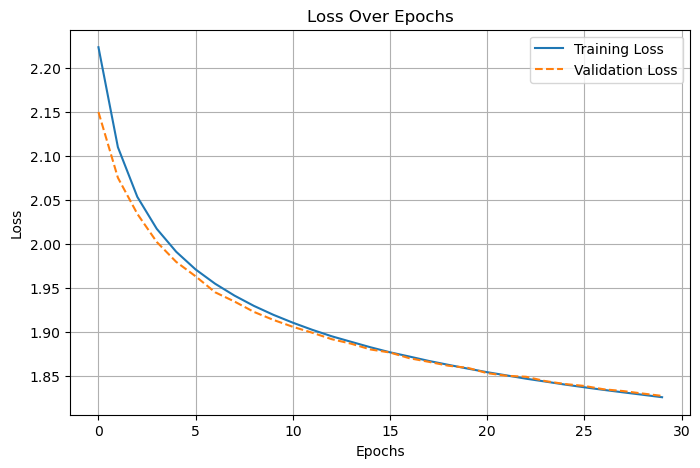

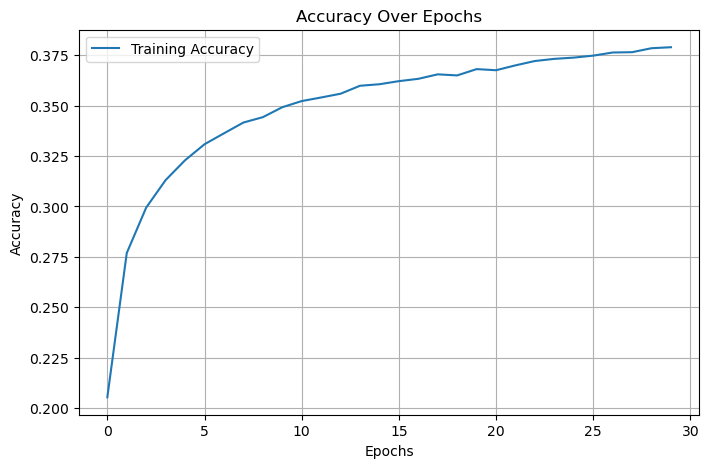

In [131]:
nn_single_sigmoid = NeuralNetwork([input_size, 100, output_size], learning_rate=0.005)

nn_single_sigmoid.layers[0].activation = "sigmoid" 
nn_single_sigmoid.layers[-1].activation = "softmax"

# Training
single_sigmoid_loss, single_sigmoid_accuracy, single_sigmoid_val_loss = nn_single_sigmoid.train(
    X_train_flat, y_train, X_valid_flat, y_valid, epochs=epochs, batch_size=64
)

# Plot the loss graph
nn_single_sigmoid.plot_loss(single_sigmoid_loss, single_sigmoid_val_loss)

# Plot the accuracy graph
nn_single_sigmoid.plot_accuracy(single_sigmoid_accuracy)


## Sources
- Loading in the CIFAR-10 Dataset:
  https://www.kaggle.com/code/farzadnekouei/cifar-10-image-classification-with-cnn/notebook
  Details on how to load the dataset and ability to see the set of images.
- Deep Neural net with forward and back propagation:
  https://www.geeksforgeeks.org/deep-neural-net-with-forward-and-back-propagation-from-scratch-python/
  Used to understand what forward and backward propagation is and basics of a NN.
  No code was taken.